- Recombine the final sequece and croos over between the weak links -> needed a custum function, maybe full deterministic
- Stats and dataframe for the SNP and other variants
- Implement gaps NNNNN

In [1]:
from Bio import pairwise2
from Bio import SeqIO
import yaml
from math import modf
from Bio.Seq import Seq
from inspyred import swarm
from inspyred import benchmarks
from inspyred import ec
from inspyred.ec import selectors
from collections import deque
import numpy as np
from itertools import combinations
import random
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed


In [2]:
from itertools import combinations
i = np.arange(10,)
j = np.arange(20)
for i in combinations(i,2):
    print(i)

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 7)
(6, 8)
(6, 9)
(7, 8)
(7, 9)
(8, 9)


In [3]:
seq=""
for seq_record in SeqIO.parse("C:\\Users\\filoa\\OneDrive\\Desktop\\Programming_trials\\Ant_colony_assembly\\GCA_014117465.1_ASM1411746v1_genomic.fna", format="fasta"):
    seq += seq_record.seq.upper()
print(len(seq))

36995582


There are 1 bases that have 0 coverage.


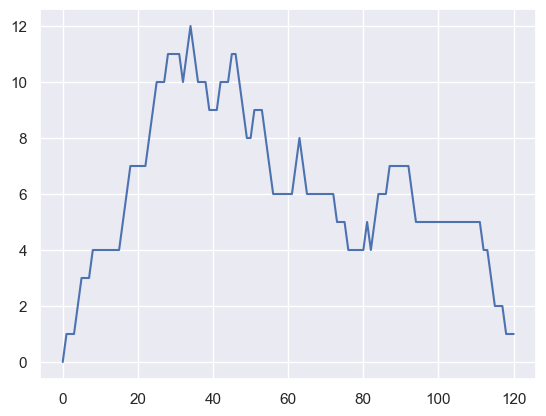

In [13]:
ref = """ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTCAGGAAACATTTTCAGACCTATGGAAACTACTTCCTGAAAACAACGTTCTGTCCCCCTTGCCGTCCCAAGCAATGGATGATTTGATGCTGTCCCCGGACGATATTGAACAATGGTTCACTGAAGACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCCCGTGGCCCCTGCACCAGCAGCTCCTACACCGGCGGCCCCTGCACCAGCCCCCTCCTGGCCCCTGTCATCTTCTGTCCCTTCCCAGAAAACCTACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTGGGACAGCCAAGTCTGTGACTTGCACGTACTCCCCTGCCCTCAACAAGATGTTTTGCCAACTGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGGTCTGGCCCCTCCTCAGCATCTTATCCGAGTGGAAGGAAATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATAGTGTGGTGGTGCCCTATGAGCCGCCTGAGGTTGGCTCTGACTGTACCACCATCCACTACAACTACATGTGTAACAGTTCCTGCATGGGCGGCATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGAGGAAGAGAATCTCCGCAAGAAAGGGGAGCCTCACCACGAGCTGCCCCCAGGGAGCACTAAGCGAGCACTGCCCAACAACACCAGCTCCTCTCCCCAGCCAAAGAAGAAACCACTGGATGGAGAATATTTCACCCTTCAGATCCGTGGGCGTGAGCGCTTCGAGATGTTCCGAGAGCTGAATGAGGCCTTGGAACTCAAGGATGCCCAGGCTGGGAAGGAGCCAGGGGGGAGCAGGGCTCACTCCAGCCACCTGAAGTCCAAAAAGGGTCAGTCTACCTCCCGCCATAAAAAACTCATGTTCAAGACAGAAGGGCCTGACTCAGACTGA"""

def comstum_reads(seq: str, length_reads = 10, coverage = 5, verbose = False) -> list:
    
    """The function split the sequence in input in reads.
    The splitting is done using random numbers, the amount of reds is given by: (len(seq)/length_read)*coverage.
    """

    number_of_reads = int(len(seq)/length_reads) * coverage
    starting_pos = random.sample(range(0, len(seq)-length_reads+1), number_of_reads)
    reads = []

    for num in starting_pos:
        reads.append(seq[num:num+length_reads])

    if verbose == True:
        # This part has the only aim to show some stats on the reads
        y = [0 for i in range(0,len(seq)+1)]
        for i in starting_pos:
            for j in range(i, i+length_reads+1):
                y[j] += 1 
        sns.set_theme(style="darkgrid")
        sns.lineplot(y)
        print(f"There are {y.count(0)} bases that have 0 coverage.")

    return reads

In [14]:
READS = comstum_reads(seq[:120], length_reads=30, verbose=True, coverage=6)
GLOBAL_MATRIX = np.zeros(len(READS), len(READS))

def alligner(nodes: tuple) -> None:
    """
    The functions need a amatrix of zeros and the reads to be initialized out of the function
    Nodes: indeces of the reads as tuple
    """
    par = [3, -2, -40, -40]
    allignment = pairwise2.align.localms(Seq(READS[nodes[0]]), Seq(READS[nodes[1]]), par[0], par[1], par[2], par[3])[0]
    start = allignment[3]
    over = allignment[4] - start

    if allignment[0][0] == "-":
        # This means that the first reads in input has a gap at the beginning of the allignment.
        # Therefore the first reads in input (i) is downstream,
        # so I add the score in the matrix but in the position (j,i) instead of (i,j) where there is a 0
        diff = allignment[0].count("-")
        GLOBAL_MATRIX[j][i] = allignment[2]*over
        GLOBAL_MATRIX[i][j] = float(f"{diff}.{start}1")
        # to avoid to loosing a 0 is been introduced a 1 digit which will be removed afterwords

    else:
        # In the opposite case, where the i read is upstream (i,j) has the score, while (j,i) has a 0   
        diff = allignment[1].count("-")               
        GLOBAL_MATRIX[i][j] = allignment[2]*over
        GLOBAL_MATRIX[j][i] = float(f"{diff}.{start}1")

    return None

def multithreading() -> None:
    length = len(READS)    
    thread = np.arange(length)
    allignment = Parallel(n_jobs=-1)(delayed(alligner)(i) for i in combinations(thread,2))
    return None

multithreading()

TypeError: Cannot interpret '24' as a data type

In [4]:
def eval_allign(reads:list, par = [3, -2, -40, -40]):
    """This function create a matrix with the alignment values of the different reads and
    contain also indexes fondamental for the sequence recostruction.

    reads: list of string representing the reads

    par: list of parameters to performe the alignment
    Ex (defoult parameters):
    match_score = 3,
    mismatch_penalty = -2,
    gap_open_penalty = -40,
    gap_extension_penalty = -40

    output:
    Matrix with the weigts (distances) between the reads (nodes)
    In this matrix there are both the scores of the alignment, recognizable for the tipical integer score and
    a flot number which is needed after to recompose the sequence, it indicates the overlapping bases.
    Ex:
        allignment score -> 2.0, 13.0, ...
        overlapping number -> 12.24, 1.6, 19.56, ...
            the number before the dot (.) is the shift, at which position the second read is alligned in respect to the first read,
            while the second is the starting position of the allignment (referred to the first). To avoid problem later
            with 0 a 1 digit is added for then remove it. So 12.30 become 12.301 but the corret indices are 12 and 30.

        These two numbers are link by the position in the matrix which are the trasposition
        Score 14.0 in position (1,5) --> 12.14 in position (5,1). Only the score position is referred
        to the direction of the edge.
        1 ---> 5 with allignment score 14 and read_1 is overlapped with read_5 in positions from 14 and
        the second read map starting to the position 12 of the first read

    Example of a matrix with three reads:

        | 1    | 2    | 3    
     1  | 0    |3.0   |12.231 
     2  |34.601|  0   | 23.0
     3  | 18.0 |45.701|  0
    """
    #  TODO use tensors

    length = len(reads)
    # initialization of the matrices
    weigth_matrix = np.zeros((length, length))

    # The score of the allingment of read[1] to read[2] is the same of the opposite (read[2] to read[1])
    # So when the function found the diretionality of the allignment put the score in rigth spot and a 0 in the wrong one.
    visited = deque([j for j in range(length)])
    
    for i in range(length):

        for j in visited:

            if i == j:
                # the diagonal of the matrix has 0 score because we are allinging the same sequence
                continue
            else:
                # pairwise must return a positive score, if there is no one it return None
                allignment = pairwise2.align.localms(Seq(reads[i]), Seq(reads[j]), par[0], par[1], par[2], par[3])
                if len(allignment) == 0:
                    continue
                else:
                    allignment= allignment[0]
                      
                start = allignment[3]
                over = allignment[4] - start
                # return object [seqA, seqB, score, start(inc), end(ex)]

                if allignment[0][0] == "-":
                    # This means that the first reads in input has a gap at the beginning of the allignment.
                    # Therefore the first reads in input (i) is downstream,
                    # so I add the score in the matrix but in the position (j,i) instead of (i,j) where there is a 0
                    diff = allignment[0].count("-")
                    weigth_matrix[j][i] = allignment[2]*over
                    weigth_matrix[i][j] = float(f"{diff}.{start}1")    # to avoid to loosing a 0 is been introduced a 1 digit which will be removed afterwords

                else:
                    # In the opposite case, where the i read is upstream (i,j) has the score, while (j,i) has a 0   
                    diff = allignment[1].count("-")                 #
                    weigth_matrix[i][j] = allignment[2]*over
                    weigth_matrix[j][i] = float(f"{diff}.{start}1")

                    
        visited.popleft()
    return weigth_matrix

In [5]:
def matrix_print(matrix:list)->None:
    
    traslator = {1:"A", 2:"T", 3:"C", 4:"G", 0:"-"}
    line = []
    for i in range(len(matrix)):
        line.append("")
        for j in range(len(matrix[0])):
            line[i] += traslator[matrix[i][j]]
        print(line[i])

    return         

In [43]:
def consensus_sequence(path:list, reads:list, positions:list, length:int, last = False, max_coverage= 12, verbose = False) -> str:
    """Rebluild from the list of reds, the path and the matrix with the scores the allignment.

    path:list of tuple with edges --> [(1,3), (3,6), ...]
    reads: list of the reads ---> ["ATCGA", "AGGCTG", ...] 
    positions: is the weigth matrix, but will be considered only the number linked with the base overlapping
    length: is needed to construct the matrix and to not initialise a awfully big useless matrix
    max_coverage: other parameter to decide how many rows the matrix need to have
    verbose: to see stats

    output: a string with the sequece reconstructed  

    Ex
        path = [(6,5), (5,9), (9,11), (11,7), (7,4), (4,1), (1,3)]
        reads = ['RAGIL', 'LISTI', 'LIFRA', 'STICH', 'GILIS', 'ERCAL', 'SUPER', 'FRAGI', 'ILIST', 'RCALI', 'PERCA', 'ALIFR']
        positions: for space reason the matrix is not presented, but is similar to the one in the eval_allign help.
    """

    if last:
        # If == True we are at the last recostruction so we want to keep more information, rather then only the length
        # so to store the each base there is the need to build a matrix.
        # As collateral, but to much a collateral a Data frame will be creted to store SNP and others infos

        D = {"A":1, "T":2, "C":3, "G":4}
        d = {1:"A", 2:"T", 3:"C", 4:"G", 0:"-"}
        rec = np.zeros((int(max_coverage*1.5), length))
        leng = len(rec[0])
        cum_dif = 0
        adding = np.zeros((int(max_coverage*1.5), max(int(length/100),len(reads[0]))))

        for i,j in path:
            # Here i,j represent the edge of the graph, to retrive not the score but the alignment
            # the function needs the opposite position where there are these informations matrix[j][i]

            num = str(positions[j][i]).split(".")
            dif = int(num[0])

            # This part extend the matrix if it is quite full
            if length - cum_dif < 2*len(reads[j]):
                rec = np.append(rec, adding, 1)

            # The first iteration is separete from the others because is the only one in which two reads are added
            if cum_dif == 0:

                # temp is a variable introduce to iterate over the reads bases
                temp = 0
                
                for pos in range(len(reads[i])):
                    rec[0, pos] = D[reads[j][temp]]
                    temp += 1
                cum_dif += dif

                temp = 0

                for pos in range(cum_dif, cum_dif + len(reads[j])):
                    rec[0, pos] = D[reads[j][temp]]
                    temp += 1
                end = len(reads[j]) + dif

            else:
                
                # The starting position from which the matrix is filled is the cumulative sum of the differences in starts
                # this concept is quite hart to grab is tried only in mind
                #  -------
                #     ------
                # dif is 3 so we start from position 3
                # row is needed to not replace any bases
                cum_dif += dif
                row = 0
                temp = 0

                while rec[row, cum_dif] != 0:
                    row += 1
                
                for pos in range(cum_dif, cum_dif+len(reads[j])):
                    rec[row, pos] = D[reads[j][temp]]
                    temp += 1
                    end += 1

        if verbose:
            matrix_print(rec)
            # TODO implement statistics
            
        cons_seq = ""
        data = np.zeros((end,4))
        for i in range(0, leng):
            base = [int(x) for x in rec[:,i] if x > 0]
            if base == []:
                return cons_seq
            ind = []
            for num in [1,2,3,4]:
                ind.append(base.count(num))
            data[i,:] = ind 
            more_frequent = ind.index(max(ind)) + 1
            cons_seq += d[more_frequent]
        data = pd.DataFrame(data, columns=["A", "T", "C", "G"])
        

        return cons_seq

    else:
        # There is no need to rebuild the sequence if the istance in not last = True
        tot_seq = 0

        for i,j in path:

            num = str(positions[j][i]).split(".")
            dif = int(num[0])
            cnt = 0
        
            if cnt == len(path)-1:
                tot_seq += dif + len(reads[j])
            else:
                tot_seq += dif
                cnt += 1
        
        return tot_seq   

In [7]:
def tuning_parameters(yaml_file = "training.yaml"):
    """This function is just to tune the parameter of the function
    """

    with open(yaml_file, "r") as file:
        file = yaml.safe_load(file)

    sequences = file["sequence_to_test"].values()
    parameters = file["allignment_parameters"].values()

    with open(yaml_file, "a") as y_file:

        for name_sequence in sequences:
            seq = ""
            y_file["scores"] = {}
            for param in parameters:
                print(name_sequence[7:-4])
                print(param)
                for seq_record in SeqIO.parse(name_sequence, format="fasta"):
                    seq += seq_record.seq.upper()
                print(seq[:80])
                y_file["scores"]
                # run algorithm
                # file["scores"]
                # file["scores"][f"{name_sequence[7:]}"][f"{parameters}"] = pairwise2.align.globalmx(our_sequence, sequence, 1, -1)[2]



In [33]:
class Assembly_problem():
    """Defines the de novo genome assembly problem.
    
    This class based on the Traveling Salesman problem defines the problem
    of assembling a new genome for which no reference is available (de novo assembly):
    given a set of genomic reads and their pairwise overlap score, find the
    path generating the longest consensus sequence. This problem assumes that 
    the ``weights`` parameter is an *n*-by-*n* matrix of pairwise 
    overlap among *n* reads. This problem is treated as a 
    maximization problem, socfitness values are determined to be the 
    proportional to the sum of the overlaps between each couple of reads
    (the weight of the edge) and the length of the final assembled sequence.
    
    Public Attributes:c
    
    - *weights* -- the two-dimensional list of pairwise overlap 
    - *components* -- the set of ``TrailComponent`` objects constructed
      from the ``weights`` attribute, where the element is the ((source,
      destination), weight)
    - *bias* -- the bias in selecting the component of maximum desirability
      when constructing a candidate solution for ant colony optimization 
      (default 0.5)
    """
    
    def __init__(self, reads, approximate_length):
        self.weights = eval_allign(reads)
        self.reads = reads
        self.components = [swarm.TrailComponent((i, j), value=(self.weights[i][j])) for i, j in itertools.permutations(range(len(self.weights)), 2) if modf(self.weights[i,j])[0] == 0]
        self.bias = 0.5
        self.bounder = ec.DiscreteBounder([i for i in range(len(self.weights))])
        self.best_path = None
        self.maximize = True
        self.length = approximate_length


    def generator(self, random, args):
            """Return a candidate solution for an evolutionary computation."""
            locations = [i for i in range(len(self.weights))]
            random.shuffle(locations)
            return locations
    
    def constructor(self, random, args):
        """Return a candidate solution for an ant colony optimization."""
        self._use_ants = True
        candidate = []
        feasible_components = [1]   #Fake initialization to allow while loop to start
        
        # We need to visit all the nodes that CAN be visited, the graph is directed and not complete, meaning we can have no more nodes to visit without visiting all the
        # nodes in the graph, thus, our termination condition is not visitin all the nodes but not having anymore feasible components
        while len(feasible_components) > 0:
            # At the start of the visit, all the components are feasible
            if len(candidate) == 0:
                feasible_components = self.components
            elif len(candidate) == len(self.weights) - 1: # All the nodes have been visited
                return candidate
            else:
                # Update feasible components and set of already visited nodes considering the node visited in the last iteration
                last = candidate[-1]
                already_visited = [c.element[0] for c in candidate]
                already_visited.extend([c.element[1] for c in candidate])
                already_visited = set(already_visited)
                feasible_components = [c for c in self.components if c.element[0] == last.element[1] and c.element[1] not in already_visited]
            if len(feasible_components) == 0:
                return candidate
            # Choose a feasible component
            if random.random() <= self.bias:
                next_component = max(feasible_components)
            else:
                next_component = selectors.fitness_proportionate_selection(random, feasible_components, {'num_selected': 1})[0]
            candidate.append(next_component)
        return candidate
    
    def cross_over(path:list, matrix:list)->list:
        """This function recombine the solution. Takes the path and the score associated to each edge
        iterate over the path and switch two edge.
        """
        imaginary_string = range(len(path))

        min_1 = path.index(min([c.value for c in path]))
        min_2 = path.index(min([c.value for c in path if (c.element[0] == min_1[0]) and (c.element[1] == min_1[1])]))
        return None
    
    def evaluator(self, candidates, args):
        """Return the fitness values for the given candidates."""
        # TODO use normal distribution
        fitness = []
        for candidate in candidates:
            total = 0
            for c in candidate:
                total += self.weights[c.element[0]][c.element[1]]
            last = (candidate[-1].element[1], candidate[0].element[0])
            current_path=[(i.element[0],c.element[1]) for i in candidate] # maybe i is enough
            total += self.weights[last[0]][last[1]]
            current_sequence = consensus_sequence(current_path, reads=self.reads, positions=self.weights, length=self.length)
            length_score = abs((self.length-current_sequence)/self.length)
            s = [5, 3, 1, 0.5, 0.2]
            perc=[0, 0.01, 0.05, 0.08, 0.1, 0.2]
            l_score = 0.1
            for i in range(len(perc)-1):
                if length_score >= perc[i] and length_score < perc[i+1]:
                    l_score = s[perc.index(perc[i])]

            if self.best_path == None or len(current_path) > len(self.best_path):
                self.best_path = current_path
            
            score = total*l_score
            fitness.append(score)

        return fitness

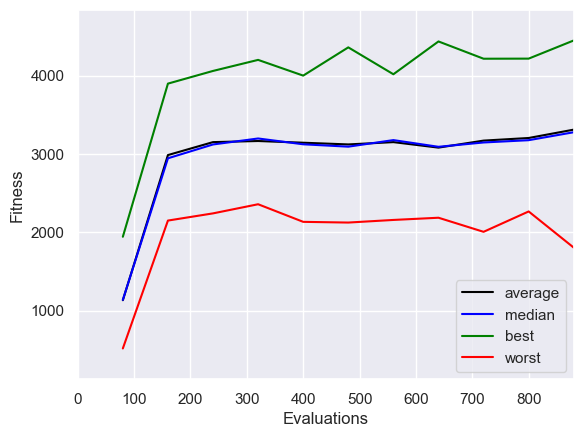

In [47]:
import inspyred
import random
from utils.utils_07.exercise_1 import *
from utils.utils_07.plot_utils import *

import collections
collections.Iterable = collections.abc.Iterable
collections.Sequence = collections.abc.Sequence

# common parameters
pop_size = 80
max_generations = 10
seed = 12
prng = Random(seed)
display = True
# ACS specific parameters
evaporation_rate = 0.4
learning_rate = 0.1

args = {}
args["fig_title"] = "ACS"

# run ACS
problem = Assembly_problem(reads, 120)
mat = problem.weights
ac = inspyred.swarm.ACS(prng, problem.components)
ac.observer = [plot_observer]
ac.terminator = inspyred.ec.terminators.generation_termination

final_pop = ac.evolve(generator=problem.constructor, 
                      evaluator=problem.evaluator, 
                      bounder=problem.bounder,
                      maximize=problem.maximize, 
                      pop_size=pop_size,
                      max_generations=max_generations,
                      evaporation_rate=evaporation_rate,
                      learning_rate=learning_rate,**args)
best_ACS = max(ac.archive)


In [48]:
c = [(i.element[0], i.element[1]) for i in best_ACS.candidate]
d = consensus_sequence(c, reads, length=120, positions=problem.weights, last=True)
print(len(d))
al = pairwise2.align.localms(d, seq[:120], 1,-0,-0,-0)[0]
print(al[0])
print(al[1])
print(al[2])


120
CCCGAAGCATGAGTGTTTACAATGTTCGAACACCTTATACAGTTCTTATACATACACGATGCGAGCAATCAAATTTCATAACATCACCATGAGTTTGGTCCGAAGCAT-A-T----A----G----AA-A--T-A--CA-------------C---
-------C--GA----TTA-AA-----G--------AT--AG-----A-A-ATACACGATGCGAGCAATCAAATTTCATAACATCACCATGAGTTTGGTCCGAAGCATGAGTGTTTACAATGTTCGAACACCTTATACAGTTCTTATACATACTTT
84.0
